# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: José Manuel Rubio Cienfuegos

Fecha de entrega: 16 de octubre de 2020

Para la **corrección automática** hemos creado una funcionalidad nueva que les permite comprobar el tiempo que demora su solución. En colab estos tiempos pueden ser variables entre una ejecución y otra del mismo código. No se preocupen si les falla el test por `time` algunas veces. Pueden hacer `time=0` en la ultima linea de cada test para evitar estos errores. También hemos usado nombres para los tests. Estos pueden serles de ayuda para determinar qué partes de su implementación deben corregir ;-)


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-vhv1xepv/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-vhv1xepv/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5801 sha256=3b688372a962d9063a027bb87e59d2b572e93bdde881e73b8c75a3ed0b6aff95
  Stored in directory: /tmp/pip-ephem-wheel-cache-_u_6mmqf/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Preliminares: funciones de activación y función de error


## 1a) Derivando las funciones de activación

Escribe acá tus respuestas para las derivadas de cada función de activación.
<br>

\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} = \frac{\text{relu}(x)}{x} = \frac{x+|x|}{2x} = \left\{ \begin{array}{c}
\left(\displaystyle 1,x \geq 0\right)\\
\left(\displaystyle 0, x<0 \right )
\end{array} \right. \\
\end{equation}
<br>

\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = & sig(\beta x) + x\beta(sig(x)(1-sig(x)) = \frac{1}{1+e^{-\beta x}} + \frac{x\beta e^{-x}}{(1+e^{-x})^{2}} \\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & = & x^{2}sig(\beta)(1-sig(\beta)) = \frac{x^{2}}{1+e^{\beta}}(1-\frac{1}{1+e^{-\beta}}) \\
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & = & \left\{ \begin{array}{c}
\left(\displaystyle 1,x \geq 0\right)\\
\left(\displaystyle e^{\frac{x}{\alpha}}, x<0 \right )
\end{array} \right.
 \\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = & \left\{ \begin{array}{c}
\left(\displaystyle 0,x \geq 0\right)\\
\left(\displaystyle e^{\frac{x}{\alpha}}(1-\frac{x}{\alpha}) - 1, x<0 \right )
\end{array} \right. \\
\end{eqnarray}

In [ ]:
# Más adelante en la tarea necesitaremos usar las funciones de activación 
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def relu(T, gradient=False):
  r, c = T.size()
  T_ones, T_zeros = torch.ones([r, c]), torch.zeros([r, c])
  if gradient:
    return torch.where(T>0, T_ones, T_zeros)
  else:
    return torch.where(T>0, T, T_zeros)

def swish(T, beta, gradient=False, gradient_beta=False):
  r, c = T.size()
  beta = beta*torch.ones([r,c])
  if gradient:
    return sig(beta*T) + beta*T*(sig(T)*(1 - sig(T)))
  if gradient_beta:
    return T*T*sig(beta)*(1 - sig(beta))
  else:
    return T*sig(beta*T)

def celu(T, alpha, gradient=False, gradient_alpha=False):
  r, c = T.size()
  T_ones, T_zeros = torch.ones([r,c]), torch.zeros([r,c])
  if alpha == 0:
    raise ValueError("alpha cannot be 0")
  if gradient:
    return torch.where(T>=0, T_ones, torch.exp(T/alpha))
  if gradient_alpha:
    return torch.where(T>=0, T_zeros, torch.exp(T/alpha)*(1 - T/alpha) - 1)
  else:
    return torch.where(T>=0, T, alpha*(torch.exp(T/alpha)-1))

## 1b) Entropía Cruzada

In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta  
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando 
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  r, c = Q.size()
  if estable:
    epsilon_tensor = epsilon*torch.ones([r, c], dtype=torch.float32)
    Q = torch.where(Q<=epsilon, epsilon_tensor, Q)
  CE_pq = -torch.sum(P*torch.log(Q), dim=1)
  return torch.mean(CE_pq)

In [ ]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="1b", test=test, token=token, answer=result, time=0)

Using cached test data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Old method `sumbit` has been renamed to `submit`, please use that instead.
  if sys.path[0] == '':


Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!


## 1c) Opcional: Entropía Cruzada Categórica

In [ ]:
# No es necesario que entregues código en esta parte.
# Pero si quieres, igual hay espacio ;-)

# Parte 2: Más derivadas y back propagation

## 2a) Derivando la última capa

Escribe tu cálculo acá.
<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = ?
\end{equation}

\begin{equation}
u^{(L+1)} = h^{(L)}U + C
\end{equation}

\begin{equation}
\cal L = \frac{1}{B} \sum^{B}_{k}\sum_{i}^{C} y_{i}log(\frac{1}{\hat{y}_{i}})
\end{equation}

$B, C$ corresponden al tamaño del *batch* y la cantidad de clases respectivamente.

**Resolución:**

En primer lugar se tiene que la predicción $\hat{y}=softmax(u^{(L+1)})$, siendo este el output de la red neuronal, entonces se tiene una composición de funciones, por ende: 

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{\partial \cal L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial u^{(L+1)}}
\end{equation}

Por ende, se deben calcular en primer lugar las derivadas de la predicción de última función (softmáx) en función de la última capa. Entonces se tiene lo siguiente:

\begin{equation}
\hat{y}_{i} = \frac{e^{x_{i}}}{\sum_{k}e^{x_{k}}}
\end{equation}

Si se esta derivando en función de $x_{j}$ donde $i=j$ entonces:

\begin{equation}
  \frac{\partial \hat{y}}{\partial x_{j}} = \frac{e^{x_{j}}\sum_{k}e^{x_{k}} - e^{2x_{j}}}{(\sum_{k}e^{x_{k}})^{2}} = \hat{y}_{j} - \hat{y}_{j}^{2}
 = \hat{y}_{j}(1 - \hat{y}_{j}) \end{equation}

 Por otro lado si $i \not= j$ entonces se tiene:

 \begin{equation}
 \frac{\hat{y}}{x_{j}} = \frac{-e^{x_{j}x_{i}}}{(\sum_{k}e^{x_{k}})^{2}} = -\hat{y}_{i}\hat{y}_{j}
 \end{equation}

 Teniendo esto, entonces calculando $\frac{\partial \cal L}{\partial \hat{y_{j}}}$:

 \begin{equation}
 \frac{\partial \cal L}{\partial \hat{y}_{j}} = \frac{1}{B} \sum_{j}^{C} y_{j}\frac{\partial log(\frac{1}{\hat{y}_{j}})}{\partial \hat{y}_{j}} =- \frac{1}{B} \sum_{j}^{C}\frac{y_{j}}{\hat{y}_{j}}
 \end{equation}

 Añadiendo $\frac{\partial \hat{y}_{j}}{u^{(L+1)}_{j}}$ a esta expresión usando las derivadas $\hat{y}_{j}$ obtenidas anteriormente entonces se tiene:

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}_{j}} = \frac{1}{B}\sum_{j}^{C}\frac{y_{j}}{\hat{y}_{j}} \cdot \frac{\partial \hat{y}_{j}}{\partial u^{(L+1)}} = -\frac{1}{B} \frac{\not{\hat{y}_{i}}(1-\hat{y}_{i})y_{i}}{\not{\hat{y}_{i}}} - \sum_{j\not= i}^{C}\frac{y_{j}}{\not{\hat{y}_{j}}}\hat{y}_{i}\not{\hat{y}_{j}} \\
\frac{\partial \cal L}{\partial u^{(L+1)}_{j}} = \frac{1}{B}(-y_{i} + y_{i}\hat{y}_{i} + \hat{y}_{i}\sum_{j\not= i}^{C}y_{j}) = \frac{1}{B} \hat{y}_{i}\not{\sum_{j}^{C} y_{j}} - y_{i} \\
\frac{\partial \cal L}{\partial u^{(L+1)}_{j}} = \frac{1}{B}(\hat{y}_{i} - y_{i})
\end{equation}

Donde se tiene que $\sum_{j}^{C} y_{j} = 1$, por ende finalmente se tiene que:

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{1}{B}(\hat{y} - y)
\end{equation}
<br>
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

## 2b) Derivando la última capa (continuación)

Escribe tus respuestas acá.

**Resolución**

Siguiendo el resultado obtenido anteriormente, entonces se tiene que lo siguiente:
<br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)}}{\partial U} \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)}}{\partial c} \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)}}{\partial h^{(L)}} \\
\end{equation}
<br>

Dado que el primer término ya se calculó, entonces se tiene que esto se reduce a realizar las derivadas $\frac{\partial u^{(L+1)}}{\partial U}, \frac{\partial u^{(L+1)}}{\partial c}, \frac{\partial u^{(L+1)}}{\partial h^{(L)}}$ y luego realizar las operaciones necesarias para que las dimensiones queden bien definidas. Entonces se tiene lo siguiente:

\begin{equation}
\frac{\partial\cal L}{\partial U_{i}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \cdot \frac{\partial u^{(L+1)}_{j}}{\partial U_{i}}  \Longrightarrow u^{(L+1)}_{j} = h_{jk}U_{k} + c\\
\end{equation}

De la última expresión solo nos importa cuando $k=i$, entonces:

\begin{equation}
\frac{\partial u^{(L+1)}_{j}}{U_{i}} =  h_{ji}^{L} \\
\frac{\partial \cal L}{\partial U_{i}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \cdot h_{ji}^{L} \Longrightarrow \frac{\partial \cal L}{\partial U} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot h^{(L)}
\end{equation}

Mediante desarrollos similares se obtienen lo siguiente:
\begin{equation}
\frac{\partial \cal L}{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \cdot \frac{\partial u^{(L+1)}_{j}}{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \cdot 1_{i} = sum(\frac{\partial \cal L}{\partial u^{(L+1)}}) \Longrightarrow \frac{\partial \cal L}{\partial c} = sum(\frac{\partial \cal L}{\partial u^{(L+1)}})
\end{equation}

Finalmente, con respecto a $h^{L}$:

\begin{equation}
\frac{\partial \cal L}{\partial h^{L}} \Longrightarrow \frac{\partial \cal L}{\partial h^{L}_{ij}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{kl}} \cdot \frac{\partial u^{(L+1)}_{kl}}{\partial h^{(L)}_{ij}}
\end{equation}

De la expresión $u^{(L+1)}_{k} = h^{L}_{kl}U_{l} + c$ solo nos interesa el caso cuando $k=i, l=j$, con esto se tiene:

\begin{equation}
\frac{\partial \cal L}{u^{L+1}_{i}} \cdot U_{j} \Longrightarrow \frac{\partial \cal L}{\partial h^{(L)}_{ij}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{i}} \cdot U_{j}
\end{equation}

En pytorch no se cuenta con producto tensorial, por lo que este producto puede ser tomado como un producto matricial con $U$ traspuesta para que las dimensiones de $\frac{\partial \cal L}{\partial h^{(L)}}$ sean $(B,d_{2})$ donde $d_{2}$ corresponde a la cantidad de elementos de la capa de salida.

(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

## 2c) Derivando desde las capas escondidas

Escribe tus respuestas acá. Repite los siguientes cálculos para $\text{relu}, \text{celu}, \text{swish}$

**Resolución**

En primer lugar se cuenta con la relación conocida:
\begin{equation}
h^{k} = f(u^{k}) \\
u^{k} = h^{k-1}W^{k} + b^{k}
\end{equation}

 Las derivadas de $\text{relu}, \text{celu}, \text{swish}$ fueron calculadas en el punto anterior, como en el caso anterior, dado que los puntos a evaluar se encuentran dentro de la función $h, u$ entonces nuevamente se utilizará regla de la cadena para realizar esto.
<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial \cal L}{\partial h^{k}} \cdot \frac{\partial h^{k}}{\partial u^{k}} \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = \frac{\partial \cal L}{\partial u^{(k)}} \cdot \frac{\partial u^{(k)}}{\partial W^{(k)}} \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = \frac{\partial \cal L}{\partial u^{(k)}} \cdot \frac{\partial u^{(k)}}{\partial b^{(k)}} \\
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial \cal L}{\partial u^{(k)}} \cdot \frac{\partial u^{(k)}}{\partial h^{(k-1)}} \\
\end{equation}
<br>

Asumiendo conocido el valor de $\frac{\partial \cal L}{\partial h^{(K)}}$, entonces para $\frac{\partial\cal L}{\partial u^{(k)}}$ solo se debe calcular $\frac{\partial\ h^{(k)}}{\partial u^{(k)}}$. Como las funciones de activación actuan punto a punto, entonces se pueden procesar los tensores de una vez.

**Función relu**
\begin{equation}
\frac{\partial h^{(k)}}{\partial u^{(k)}} = \frac{relu(u^{(k)})}{u^{(k)}} \Longrightarrow \frac{\partial \cal L}{\partial u^{(k)}} = \frac{\partial \cal L}{\partial h^{(k)}} \cdot \frac{relu(U^{(k)})}{U^{(k)}}.
\end{equation}

**Función swish**
\begin{equation}
\frac{\partial h^{(k)}}{\partial u^{(k)}} = \sigma(\beta U^{(k)}) + \beta U^{(k)}(\sigma(U^{(k)})(1-\sigma(U^{(k)}))) \Longrightarrow \frac{\partial \cal L}{\partial u^{(k)}} = \frac{\partial \cal L}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial u^{(k)}}.
\end{equation}

**Función celu**

Para esto se tienen 2 casos:
\begin{equation}
\frac{\partial h^{(k)}}{\partial u^{(k)}_{ij}} = 1 \\
\frac{\partial h^{(k)}}{\partial u^{(k)}_{ij}} = e^{(\frac{1}{\alpha}\cdot U_{ij}^{(k)})} 
\end{equation}

La primer función sucede cuando $U_{ij}\geq 0$, mientras que la segunda relación es en caso contrario.

Ahora teniendo esto y repitiendo los procedimientos realizados al calcular las derivadas de la última capa se obtiene lo siguiente:

\begin{equation}
\frac{\partial \cal L}{\partial W_{ij}^{(k)}} = \frac{\partial \cal L}{\partial u^{(k)}_{st}} \cdot \frac{\partial u^{(k)}_{st}}{\partial W_{ij}^{(k)}} \\
u_{st}^{(k)} = h^{(k-1)}_{sl}W_{lt}^{k} + b_{t}^{(k)}
\end{equation}

Solo nos interesa cuando $l=i, t=j$, para todo lo demás sera 0. Entonces se tiene lo siguiente:

\begin{equation}
\frac{\partial u_{sj}^{(k)}}{\partial W_{ij}^{(k)}} = h_{si}^{(k-1)}
\end{equation}

Entonces:

\begin{equation}
\frac{\partial \cal L}{\partial W_{ij}^{(k)}} = \frac{\partial \cal L}{\partial u_{sj}^{(k)}} \cdot h_{si}^{(k-1)} \\
\frac{\partial \cal L}{\partial W^{(k)}} = (h^{(k-1)})^{T} @ \frac{\partial \cal L}{\partial u^{(k)}}
\end{equation}

Derivando con respecto a $b^{(k)}$ de forma análoga se tiene:

\begin{equation}
\frac{\partial \cal L}{\partial b^{(k)}} \Longrightarrow \frac{\partial \cal L}{\partial b_{i}^{(k)}} = \frac{\partial \cal L}{\partial u_{st}^{(k)}} \cdot \frac{\partial u_{st}^{(k)}}{\partial b_{i}^{(k)}} \\
u_{st}^{(k)} = h^{(k-1)}_{sl}W_{lt}^{(k)} + b_{t}^{(k)}
\end{equation}

Donde solo nos interesa cuando $t=i$, entonces se tiene lo siguiente:
\begin{equation}
\frac{\partial u_{si}^{(k)}}{\partial b_{i}^{(k)}} = 1
\end{equation}

Entonces:
\begin{equation}
\frac{\partial \cal L}{\partial b_{i}^{(k)}} = \frac{\partial \cal L}{\partial u_{si}^{(k)}} \cdot 1_{si} \\
\frac{\partial \cal L}{\partial b^{(k)}} = sum(\frac{\partial \cal L}{\partial u^{(k)}})
\end{equation}

Donde esta última expresión se suma sobre la primera dimensión, por lo que termina resultando un vector de tamaño $d_{2}$

Finalmente realizando la derivada sobre la capa anterior:

\begin{equation}
\frac{\partial \cal L}{\partial h^{(k-1)}} \Longrightarrow \frac{\partial \cal L}{\partial h_{ij}^{(k-1)}} = \frac{\partial \cal L}{\partial u_{st}^{(k}} \cdot \frac{\partial u_{st}^{(k)}}{\partial h_{ij}^{(k-1)}} \\
u_{st}^{(k)} = h^{(k-1)}_{sl}W_{lt}^{(k)} + b_{t}^{(k)}
\end{equation}

Donde nos interesa cuando $s=i, l=j$ entonces se tiene:
\begin{equation}
\frac{\partial u_{it}^{(k)}}{\partial h_{(ij)}^{(k-1)}} = W_{jt}^{(k)}
\end{equation}

Por lo que:
\begin{equation}
\frac{\partial \cal L}{\partial h_{ij}^{(k-1)}} = \frac{\partial \cal L}{\partial u_{it}^{(k)}} \cdot W_{jt}^{(k)} \\
\frac{\partial \cal L}{\partial h^{(k-1)}} = \frac{\partial \cal L}{\partial u^{(k)}} @ (W^{(k)})^{T}
\end{equation}
(No es necesario que repitas el código que era solo de ayuda para chequear las dimensiones.)

In [ ]:
# Para ir chequeando que al menos las dimensiones de los tensores son 
# consistentes usaremos las varibles *dummy* a continuación.
B, C = 5, 10
y = torch.ones(B,C)
y_pred = torch.ones(B,C)

In [ ]:
# Acá tu trozo de código. 
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas
dimL = 40
hL = torch.ones(B,dimL)
U = torch.ones(dimL,C)
c = torch.ones(C)
uLm1 = hL @ U + c

# Ahora tu fórmula para el gradiente
dL_duLm1 = (y_pred - y)/B

# El gradiente debe coincidir en dimensiones con la variable
assert dL_duLm1.size() == uLm1.size()

In [ ]:
# Acá puedes probar tus cálculos usando código. 
dL_dU = hL.t() @ dL_duLm1
dL_dc = torch.sum(dL_duLm1, dim=0)
dL_dhL = dL_duLm1 @ U.t()

# El gradiente debe coincidir en dimensiones con las variables.
assert dL_dU.size() == U.size()
assert dL_dc.size() == c.size()
assert dL_dhL.size() == hL.size()

In [ ]:
# Acá puedes probar tus cálculos usando código. 
# Primero agregamos algunas variables dummy para chequear 
# que al menos las dimensiones están correctas.
dimk = 20
dimkm1 = 30
hk = torch.ones(B,dimk)
Wk = torch.ones(dimk,dimkm1)
bk = torch.ones(dimkm1)
uk = hk @ Wk + bk
dL_dhkm1 = torch.ones(B,dimkm1)
dh_du = relu(uk, gradient=True)

# Ahora tu fórmula para el gradiente.
# Esto puedes repetirlo con tus expresiones para relu, celu, y swish.
dL_duk = dL_dhkm1 * dh_du
dL_dWk = hk.t() @ dL_duk
dL_dbk = torch.sum(dL_duk, dim=0)
dL_dhk = dL_duk @ Wk.t()

# El gradiente debe coincidir en dimensiones con las variables.
assert dL_dWk.size() == Wk.size()
assert dL_dbk.size() == bk.size()
assert dL_dhk.size() == hk.size()

# Parte 3: Backpropagation en nuestra red

## 3a) Método `backward` + parte 3b) Opcional

In [ ]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
class FFNN(torch.nn.Module):
  # código desde la Tarea 1
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    # self.fs_ps = torch.nn.ParameterList([torch.nn.Parameter(torch.tensor(p)) if p else None for p in l_a_params])

  # código desde la Tarea 1
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])

  # código desde la Tarea 1
  def resumen(self):
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
  
  # código desde la Tarea 1
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    u_layers = []
    h_layers = []
    for W, b, f in zip(self.Ws[:-1], self.bs[:-1], self.fs):
      u = torch.mm(x, W) + b
      x = f(u) 
      u_layers.append(u)
      h_layers.append(x)

    self.U_layers = u_layers
    self.H_layers = h_layers
    soft = torch.nn.Softmax(dim=1)
    return soft(torch.mm(x, self.Ws[-1]) + self.bs[-1])

  # nuevo código Tarea 2
  def backward(self, x, y, y_pred):
    # Computar acá todos los gradientes con respecto a L
    # Hint: Los gradientes deben quedar almacenados en 
    #       el atributo `grad` para cada parámetro.
    #       Más info sobre este atributo en
    #       https://pytorch.org/docs/stable/autograd.html#torch.Tensor.grad
    
    # Ultima capa:
    q_hlayer = len(self.fs)
    B = x.size()[0]
    dL_duL1 = (y_pred - y)/B
    dL_duL = self.H_layers[-1].t() @ dL_duL1
    dL_dc = torch.sum(dL_duL1, dim=0)
    dL_dhk = dL_duL1 @ self.Ws[-1].t()
    grads, params = [], []
    functions_inv, W_inv, h_inv = list(reversed(self.fs)), list(reversed(self.Ws[:-1])), list(reversed(self.H_layers)) # Volteando la lista con los parametros
    U_inv, b_inv = list(reversed(self.U_layers)), list(reversed(self.bs[:-1]))
    # Iteración para las capas ocultas
    for k in range(q_hlayer):
      f_k, u_k, w_k = functions_inv[k], U_inv[k], W_inv[k]
      dL_duk = dL_dhk * f_k(u_k, gradient=True)
      dL_dbk = torch.sum(dL_duk, dim=0)
      dL_dhk1 = dL_duk @ w_k.t()
      dL_dwk = h_inv[k+1].t() @ dL_duk if not k == q_hlayer - 1 else x.t() @ dL_duk
      dL_dhk = dL_dhk1
      grads.append(dL_dwk)
      params.append(w_k)
      grads.append(dL_dbk)
      params.append(b_inv[k])
    grads.reverse()
    grads.append(dL_duL)
    grads.append(dL_dc)
    params.reverse()
    params.append(self.Ws[-1]) # Se añade U de la ultima capa
    params.append(self.bs[-1]) # Se añade C de la última capa
    Grads, Params = grads[:], params[:]
    for p, g in zip(Params, Grads):
      p.grad = g     

In [ ]:
# Tests del API del curso
# (estos Tests NO sustituyen al anterior en la verificación de los gradientes)
for test in ['mnist-model']:
  # Obtenemos los parámetos de la red desde el API
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  l_a = [f for s in l_a for f in [sig, relu] if f.__name__ == s] # todo

  # Inicializamos modelo con parámetros del API
  your_model = FFNN(F=F, l_h=l_h, l_a=l_a, C=C)
  your_model.load_weights([torch.Tensor(l) for l in Ws], torch.Tensor(U), [torch.Tensor(l) for l in bs], torch.Tensor(c))
  
  # Obtenemos el índice del parámetro Ws[1] en la lista de parámetros de tu modelo
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Ejecutemos el forward de para input del API
  y_pred = your_model(torch.Tensor(X))
  
  # Ejecutemos el backward de tu modelo para ver como se comporta
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s
  
  # Veamos todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="3a", test=test, token=token, 
                   answer=list(your_model.parameters())[idx].grad.mean(), time=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Old method `sumbit` has been renamed to `submit`, please use that instead.


Correct Test!


## 3c) Opcional: Chequeo de gradiente

In [ ]:
# No es necesario que entregues código en esta parte dado 
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

# Parte 4: Descenso de gradiente y optimización

## 4a) Descenso de gradiente (estocástico)

In [ ]:
# Tu código debiera comenzar así

class SGD():
  def __init__(self, parameters, lr):
    # lo que sea necesario inicializar
    self.parameters = parameters
    self.lr = lr
  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    params = []
    for p in self.parameters:
      p.data -= self.lr * p.grad
      params.append(p)
    self.parameters = params

In [ ]:
# Tests del API del curso
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  # Obtengamos una lista de parámetros (con gradientes en .grad) y un valor lr
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  # Inicialicemos tu SGD
  optimizer = SGD(parameters, lr)

  # Ejecutemos un paso de tu SGD para ver como se comporta
  s = timer()
  optimizer.step()
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="4a", test=test, token=token, 
                   answer=parameters[idx].data, time=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Old method `sumbit` has been renamed to `submit`, please use that instead.


Correct Test!
Correct Test!
Correct Test!


## 4b) Datos para carga

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Aquí tu código.
# Tu clase debiera verse así
class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    R_N_f = torch.rand(N,F)
    self.X = torch.bernoulli(R_N_f)
    target = torch.randint(0, C, (N,))
    self.Y = torch.nn.functional.one_hot(target).type(torch.float32)
    self.num_features = F
  
  def __len__(self):
    return self.X.size()[0]
  
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [ ]:
# Inicialicemos un RandomDataset de prueba
N,F,C=100,300,10
your_dataset = RandomDataset(N=N, F=F, C=C)

# Veamos como se comportan __len__ y __getitem__
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]") 
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Optimizando los parámetros de la red para datos al azar

In [ ]:
# Tu código acá
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cpu'):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=True)

  # Comienza el entrenamiento
  loss, acc = [], []
  for e in range(1,epochs+1):
    for x, y in data:
      x, y = x.to(device), y.to(device)
      y_pred = red.forward(x)
      red.backward(x, y, y_pred)
      L = CELoss(y_pred, y)
      pred_values, class_values = torch.argmax(y_pred, dim=1), torch.argmax(y, dim=1)
      correctos = torch.sum(pred_values == class_values).item()
    Acc = (correctos / len(y)) * 100
    loss.append(L)
    acc.append(Acc)
    optimizador.step()
  return loss, acc

In [ ]:
F = 300
N = 500
C = 10
dataset = RandomDataset(N=N, F=F, C=C)
# model = your_model
model = FFNN(F=F,l_h=[50,30],l_a=[relu, sig], C=C)
optimizer = SGD(model.parameters(), lr=0.25)
epochs = 400
with torch.no_grad():
  loss, acc = entrenar_FFNN(model, dataset, optimizer, epochs=epochs, batch_size=500)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


## 4d) Graficando la pérdida/error en el tiempo

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

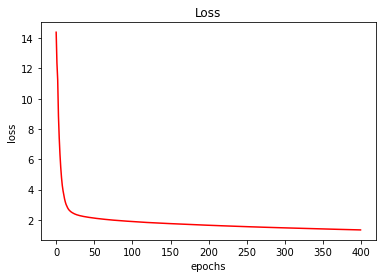

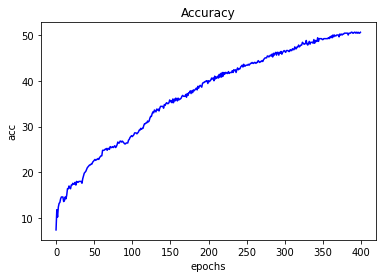

In [ ]:
plot_results(loss=loss, acc=acc)

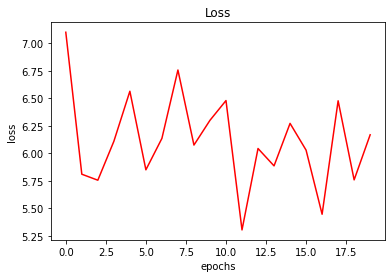

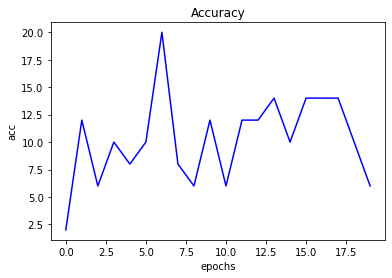

In [ ]:
plot_results(loss=loss, acc=acc)

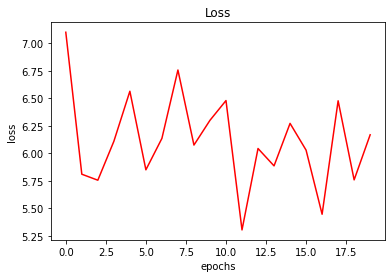

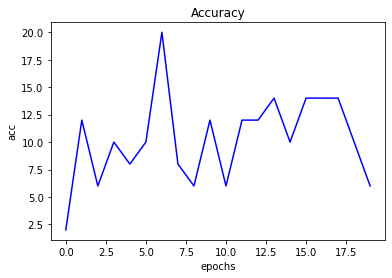

In [ ]:
plot_results(loss=loss, acc=acc)

In [ ]:
# Tu código acá

## 4e) Opcional: Optimizando tu red para MNIST

In [ ]:
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá